In [1]:
from keras.layers import Flatten, Dense, Dropout, ZeroPadding3D, Conv3D, Activation, MaxPooling3D,\
    GlobalAveragePooling3D, Average, Input
from keras.models import Model
from keras.regularizers import l2
from keras import callbacks
from keras.optimizers import Adam
from keras.losses import mean_absolute_error
import nibabel as nib
import random
import os
import csv
from sklearn.model_selection import train_test_split
import numpy as np
import sys

Using TensorFlow backend.


In [2]:
# My functions are defined in a file lib.py

%load_ext autoreload
%autoreload 2
    
import lib

In [3]:
# Set parameters

# Data types:
# wi: warped images
# wc: warped segmentations
# mwc: modulated warped segmentations
DataType = 'mwc'

PthScores = '../Scores/training_fluid_intelligenceV1.csv'
DirData   = '../Data/DownSampled-' + DataType + ''
PthModel  = '../Results/model-' + DataType + '.h5'
DirLog    = '../Log/'

TestSize  = 0.1
ValidSize = 0.2

NbEpochs  = 100
BatchSize = 32

TrainModel = True

In [4]:
# Get ABCD targets (IQ scores)

Scores = lib.get_abcd_scores(PthScores)

In [5]:
# Get training data (X,y)

if DataType   == 'wi':
    X,y,Shape = lib.get_abcd_training_data_img(DirData,Scores)
elif DataType == 'wc' or DataType == 'mwc':
    X,y,Shape = lib.get_abcd_training_data_seg(DirData,Scores)

print('Input dimensions = ' + str(Shape))

Input dimensions = (51, 66, 55, 3)


TotalSamples           = 3739, mu(y) = 0.05579177463128638, var(y) = 85.84989009890943
TotalTrainingSamples   = 2692, mu(y) = 0.0851944152883421, var(y) = 86.35078784060904
TotalValidationSamples = 673, mu(y) = -0.038357152261150614, var(y) = 83.09186004356127
TotalTestSamples       = 374, mu(y) = 0.013573376636142723, var(y) = 87.18352146437343


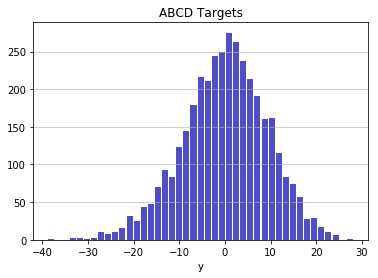

In [6]:
# Split into train, validation and test sets

X_train, X_test,  y_train, y_test  = train_test_split(X,       y,       test_size=TestSize)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=ValidSize)

TotalSamples           = len(X)
TotalTrainingSamples   = len(X_train)
TotalValidationSamples = len(X_valid)
TotalTestSamples       = len(X_test)

print('TotalSamples           = ' + str(TotalSamples) + ', mu(y) = ' + str(np.mean(np.array(y).astype(np.float)))  + ', var(y) = ' + str(np.var(np.array(y).astype(np.float))))
print('TotalTrainingSamples   = ' + str(TotalTrainingSamples) + ', mu(y) = ' + str(np.mean(np.array(y_train).astype(np.float)))  + ', var(y) = ' + str(np.var(np.array(y_train).astype(np.float))))
print('TotalValidationSamples = ' + str(TotalValidationSamples) + ', mu(y) = ' + str(np.mean(np.array(y_valid).astype(np.float)))  + ', var(y) = ' + str(np.var(np.array(y_valid).astype(np.float))))
print('TotalTestSamples       = ' + str(TotalTestSamples) + ', mu(y) = ' + str(np.mean(np.array(y_test).astype(np.float)))  + ', var(y) = ' + str(np.var(np.array(y_test).astype(np.float))))

lib.plot_histogram(np.array(y).astype(np.float))

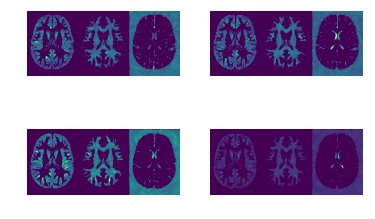

In [7]:
# Show a few training samples

lib.imshow(X_train,Shape,np.arange(4))

In [8]:
# Look at filenames and scores. To make sure that training data is OK, by comparing
# with what is in the .csv file (PthScores)

N = 2

print('------------------')
print('Training set')
X_temp = X_train
y_temp = y_train
for i in range(0,N):
    print(lib.get_filename(X_temp[i]))
    print(y_temp[i])
    print()
    
print('------------------')    
print('Validation set')
X_temp = X_valid
y_temp = y_valid
for i in range(0,N):
    print(lib.get_filename(X_temp[i]))
    print(y_temp[i])
    print()
    
print('------------------')    
print('Test set')
X_temp = X_test
y_temp = y_test
for i in range(0,N):
    print(lib.get_filename(X_temp[i]))
    print(y_temp[i])
    print()    

------------------
Training set

../Data/DownSampled-mwc/NDAR_INV6VT5M0AL/mwc2vx_cr_NDAR_INV6VT5M0AL_t1_brain.nii
../Data/DownSampled-mwc/NDAR_INV6VT5M0AL/mwc3vx_cr_NDAR_INV6VT5M0AL_t1_brain.nii
../Data/DownSampled-mwc/NDAR_INV6VT5M0AL/mwc1vx_cr_NDAR_INV6VT5M0AL_t1_brain.nii
0.188362091842734


../Data/DownSampled-mwc/NDAR_INV6EJF2KCZ/mwc2vx_cr_NDAR_INV6EJF2KCZ_t1_brain.nii
../Data/DownSampled-mwc/NDAR_INV6EJF2KCZ/mwc3vx_cr_NDAR_INV6EJF2KCZ_t1_brain.nii
../Data/DownSampled-mwc/NDAR_INV6EJF2KCZ/mwc1vx_cr_NDAR_INV6EJF2KCZ_t1_brain.nii
-6.97405752824715

------------------
Validation set

../Data/DownSampled-mwc/NDAR_INVMM3Y00ZD/mwc2vx_cr_NDAR_INVMM3Y00ZD_t1_brain.nii
../Data/DownSampled-mwc/NDAR_INVMM3Y00ZD/mwc3vx_cr_NDAR_INVMM3Y00ZD_t1_brain.nii
../Data/DownSampled-mwc/NDAR_INVMM3Y00ZD/mwc1vx_cr_NDAR_INVMM3Y00ZD_t1_brain.nii
1.83587368497107


../Data/DownSampled-mwc/NDAR_INVHJULNANY/mwc2vx_cr_NDAR_INVHJULNANY_t1_brain.nii
../Data/DownSampled-mwc/NDAR_INVHJULNANY/mwc3vx_cr_NDAR_INVHJULN

In [ ]:
# Define generators

training_generator   = lib.data_generator(X_train,y_train,Shape,BatchSize)
validation_generator = lib.data_generator(X_valid,y_valid,Shape,BatchSize)
test_generator       = lib.data_generator(X_test,y_test,Shape,BatchSize)

In [ ]:
# Define CNN regression model

model = lib.get_model(Shape)

/home/mbrud/dev/Validations/CNN-regress/Python/lib.py:81: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  return Model(input=input_layer, output=predictions)


In [ ]:
# Compile CNN model

#model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.0001), metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001), metrics=['mse'])

In [ ]:
if TrainModel:
    # Train a new model
    
    # Define callback for TensorBoard
    tbCallBack = callbacks.TensorBoard(log_dir=DirLog, 
                                       histogram_freq=0, 
                                       write_graph=True, 
                                       write_images=True)
    tbCallBack = None
    
    # Fit model
    # For training loss, keras does a running average over the batches. 
    # For validation loss, a conventional average over all the batches in validation data is performed. 
    model.fit_generator(training_generator,
                        nb_epoch=NbEpochs,
                        validation_data=validation_generator,
                        steps_per_epoch=TotalTrainingSamples/BatchSize,
                        validation_steps=TotalValidationSamples/BatchSize,
                        callbacks=tbCallBack,
                        verbose=2) # 0 = silent, 1 = progress bar, 2 = one line per epoch

    # Save trained model
    model.save(PthModel)
else:
    # Load an already trained model
        
    model.load_weights(PthModel)        

/home/mbrud/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/mbrud/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=84.125, validation_steps=21.03125, callbacks=None, epochs=100)`


Epoch 1/100
85/84 [==============================] - 487s 6s/step - loss: 2.1727 - mean_squared_error: 2.1681 - val_loss: 2.4143 - val_mean_squared_error: 2.4097
Epoch 2/100
85/84 [==============================] - 100s 1s/step - loss: 1.7938 - mean_squared_error: 1.7892 - val_loss: 3.4200 - val_mean_squared_error: 3.4155
Epoch 3/100
85/84 [==============================] - 26s 312ms/step - loss: 3.1330 - mean_squared_error: 3.1284 - val_loss: 1.8735 - val_mean_squared_error: 1.8690
Epoch 4/100
85/84 [==============================] - 26s 311ms/step - loss: 2.4032 - mean_squared_error: 2.3987 - val_loss: 1.8928 - val_mean_squared_error: 1.8883
Epoch 5/100
85/84 [==============================] - 26s 306ms/step - loss: 2.5717 - mean_squared_error: 2.5672 - val_loss: 5.0462 - val_mean_squared_error: 5.0417
Epoch 6/100
85/84 [==============================] - 26s 301ms/step - loss: 2.8299 - mean_squared_error: 2.8254 - val_loss: 3.5409 - val_mean_squared_error: 3.5364
Epoch 7/100
85/84 [=

In [ ]:
# Evaluate model on validation set

yp  = model.predict_generator(validation_generator,steps=TotalValidationSamples)
mse = np.mean(np.square(np.array(y_valid) - yp))
print('MSE = ' + float(mse)

In [ ]:
if False:
    # Evaluate model on test set

    yp  = model.predict_generator(test_generator,steps=TotalTestSamples)
    mse = np.mean(np.square(np.array(y_test) - yp))
    print('MSE = ' + float(mse)